# De Rham Neural Networks

In this notebook, we develop a few examples of simple De Rham Neural Networks.

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import coo_matrix,diags
from scipy.sparse.linalg import inv
import gudhi as gd
import copy
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import torch

## Vector Fields

We first design some plotting functions to visualize vector fields. This will help us understand the features that our algorithm is learning. 

In [2]:
## initialise a random function from R^n to R^2
def random_linear_function(input, output_dim = 2):

    # get the dimension of the input
    input_dim = np.shape(input)[0]

    # initialise a random matrix of dim input_dim x output_dim
    A = np.random.uniform(-1,1,(input_dim,output_dim))
    
    return input @ A


## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, x_range, y_range, ax):

    x = np.linspace(x_range[0],x_range[1],20)
    y = np.linspace(y_range[0],y_range[1],20)
    X,Y = np.meshgrid(x,y)


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            U[i,j] = f([X[i,j],Y[i,j]])[0]
            V[i,j] = f([X[i,j],Y[i,j]])[1]
    ax.quiver(X,Y,U,V)

    

## plot the vector field of a random function
def plot_random_vector_field():
    f = random_function()
    fig, ax = plt.subplots()
    plot_vector_field(f, [-1,1], [-1,1], ax)
    plt.show()

As a first example, we will consider vector fields over $\mathbb{R}^2$. $1$-forms, which are in bijection with and dual to vector fields, can be written in the form:
$\begin{equation} \omega = f_x(x,y) dx + f_y(x,y) dy \end{equation}$ where both $f_x$ and $f_y$ are functions from $\mathbb{R}^2$ to $\mathbb{R}$. By the identification
$ \begin{equation} \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \oplus  \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}) \cong \mathsf{Hom}(\mathbb{R}^2, \mathbb{R}^2)  \end{equation}$ we can represent a $1$-form as a single function from $\mathbb{R}^2 \to \mathbb{R}^2$. To learn such a function, we define a simple MLP below which goes from $\mathbb{R}^2 \to \mathbb{R}^2$.

In [3]:
import torch
import torch.nn as nn
 
# initialise a vector field as a MLP
vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 500),
    nn.ReLU(),
    nn.Linear(500, 2)
)

To drive home the fact that the above MLP actually defines a vector field, we can plot it. The 'tangent vector' at each point $(x,y) \in \mathbb{R}^2$ is the vector given by
$\begin{equation}  (f_x(x,y),f_y(x,y)) \end{equation}$ which corresponds to the MLP above via
$\begin{equation} f_x(x,y) = \pi_x \circ \text{vf.forward}(x,y) \end{equation}$ and $\begin{equation} f_y(x,y) = \pi_y \circ \text{vf.forward}(x,y). \end{equation}$

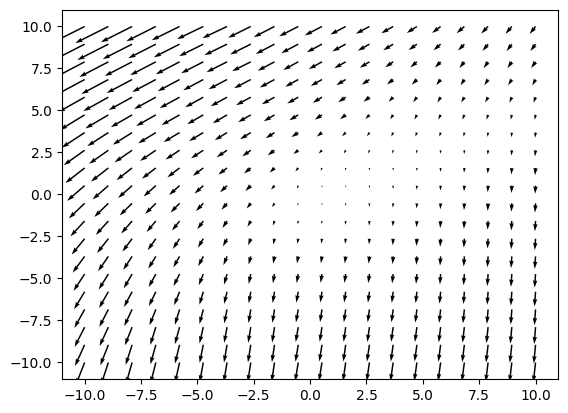

In [4]:
## plot a vector field given a function f: R^2 -> R^2
def plot_vector_field(f, ax, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()
            U[i,j] = f.forward(inp)[0]
            V[i,j] = f.forward(inp)[1]
    ax.quiver(X,Y,U,V)

fig, ax = plt.subplots()

plot_vector_field(vf, ax, x_range=10, y_range=10)

plt.show()


In [5]:
## plot a vector field given a function f: R^2 -> R^2
def plot_component_vf(f, ax, comp = 0, x_range=5, y_range=5):

    x = np.linspace(-x_range,x_range,20)
    y = np.linspace(-y_range,y_range,20)
    X,Y = np.meshgrid(x,y)

    X = torch.tensor(X).double()
    Y = torch.tensor(Y).double()


    U = np.zeros((20,20))
    V = np.zeros((20,20))
    for i in range(20):
        for j in range(20):
            inp = np.array([X[i,j],Y[i,j]])
            inp = torch.tensor(inp).float()

            tv = f.forward(inp).reshape(2,c)

            U[i,j] = tv[:,comp][0]
            V[i,j] = tv[:,comp][1]
    ax.quiver(X,Y,U,V)


Now we make a neural network that learns multiple vector fields.

In [6]:
c = 6 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 50),
    nn.ReLU(),
    nn.Linear(50, 2*c)
)

#vf.forward(torch.tensor([1,2]).float()).reshape(2,c)

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/625976827.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2, 3, i+1)


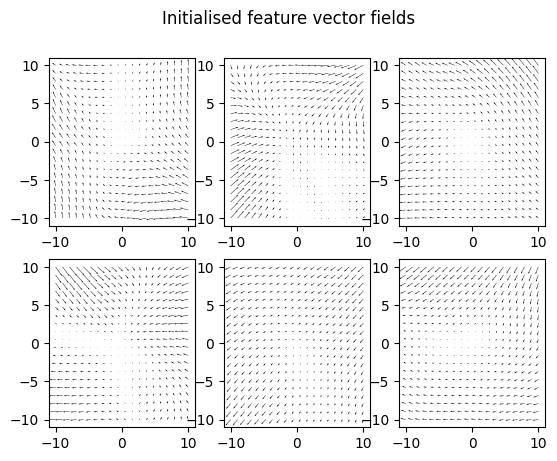

In [7]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(c):
    ax = plt.subplot(2, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)


# add a title to the figure
fig.suptitle('Initialised feature vector fields')


plt.show()


#### Calculating line integrals of vector fields along linear paths

In [8]:
# parametrize a line between two points
def line(x,y,n = 50):
    
    t = np.linspace(0,1,n)

    # make t into a column vector
    t = np.reshape(t, (n,1))

    return torch.tensor((1-t) @ x + t @ y).float()



In [9]:
l = line(np.array([[0,1]]),np.array([[1,0]]))

In [10]:
def trapz(y, l):
    """Approximate the definite integral of y=f(x) using the trapezoidal rule.

    Parameters
    ----------
    y : array_like
        Array of y values of f(x).
    l : array_like
        Array of linear values along a line in R^n.
    
    Returns
    -------
    trapz : float
        Definite integral as approximated by trapezoidal rule.

    """

    # difference between each point on the line, should be 1x(n-1)
    d = torch.norm(torch.diff(l.T).T,dim=1)

    # pointwise multiplication of y[0:-1] + y[1:] and d
    return d @ (y[0:-1,:] + y[1:,:]) / 2

In [82]:
trapz(y,l)

IndexError: too many indices for tensor of dimension 1

In [12]:
def vf_eval(vf,line):
    # evaluate the vector field vf along the line
    # vf is a torch.nn.Sequential object
    # line is a torch.tensor object
    # returns a torch.tensor object
    n = line.shape[0]
    

    # gradient of the line
    l_grad = (line[-1] - line[0])/np.linalg.norm(line[-1] - line[0])

    # turn l_grad into a column vector that automatically determines the number of rows
    l_grad = torch.reshape(l_grad, (l_grad.shape[0],1))

    # initialise empty torch tensor of size n x c
    # where c is the number of features in the cochain data matrix 
    # and n is the number of points in the line
    out = torch.zeros((n,c))

    # iterate over the columns of the cochain data matrix/number of feature 1-forms
    for j in range(c):

        # initialise empty torch tensor of size n x 2 to store innerproduct of
        # vf[j] and the gradient of the line
        local_out = torch.zeros((n,2))

        for i in range(n):
            local_out[i,:] = vf(line[i,:]).reshape((2,c))[:,j]
        
        out[:,j] = (local_out @ l_grad).T

    # return a torch tensor of size n x c
    # where n is the number of points in the line
    # and c is the number of features in the cochain data matrix
    # entries represent the inner product of the vector field 
    # and the gradient of the line at each point in the line
    return out

In [13]:
def integrate(vf,l):
    """ 
    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    l : torch.tensor object
        Line along which to integrate vf
    """
    eval = vf_eval(vf,l)
    return trapz(eval,l)

In [14]:
# integrate a vector field between two points with a given number of steps
def integrate_segment(vf, x, y, n = 5):
    """
    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    x : torch.tensor object
        Starting point of the line
    y : torch.tensor object
        End point of the line
    n : int
        Number of steps to take along the line
    """
    l = line(x,y,n)
    
    return integrate(vf,l)



In [15]:
def generate_cochain_dm(vf, points, n = 50):
    """
    A function to generate the cochain data matrix for a path of points in R^m
    against a vector field
    ----------

    Parameters
    ----------
    vf : torch.nn.Sequential object
        Vector field to be integrated
    points : torch.tensor object (m x r)
        Sequence of points in R^m representing a path
    n : int
        Number of steps to take along each line
    """

    r = points.shape[0]-1

    # initialise empty torch tensor of size r x c
    # where c is the number of features in the cochain data matrix
    # and r is the number of lines between points
    out = torch.zeros((r,c))

    for i in range(r):
        out[i,:] = integrate_segment(vf,np.array([points[i,:]]),np.array([points[i+1,:]]), n = n)

    return out

### Synthetic Dataset of paths

In [16]:
## plot a set of points and connect consecutive points with lines
def plot_points(points, ax, color = 'black', alpha = 1, linewidth = 1):

    n = points.shape[0]

    for i in range(n-1):
        ax.plot(points[i:i+2,0],points[i:i+2,1], color = color, alpha = alpha, linewidth = linewidth)

    return ax


In [17]:
def generate_diagonal_paths(num_paths=100,eps = 0.2, num_pts = 10):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        x_values = list(x+noise_x +x_trans)
        y_values = list(np.sin(x+noise_y)+y_trans)

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths


def generate_antidiagonal_paths(num_paths=100,eps = 0.2, num_pts = 10):
    
    Paths = []
    for i in range(num_paths): 
        x = np.sort(np.random.uniform(low=-1, high=1, size=num_pts))

        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        x_values = list(x+noise_x +x_trans)
        y_values = list(-np.sin(x+noise_y)+y_trans)
        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)
        
    return Paths
        



def generate_circular_paths(num_paths=100,eps = 0.2, num_pts = 10):
    
    Paths = []
    for i in range(num_paths): 
        endpoint = np.random.randint(0,num_pts)
        
        sample_angles = list(np.sort(np.random.uniform(0,2*np.pi, num_pts)))
        angles= sample_angles[endpoint:]+ sample_angles[:endpoint]
        angles = np.array(angles)
        
        noise_x= np.random.uniform(low= -eps, high = eps,  size = num_pts)
        noise_y= np.random.uniform(low= -eps, high = eps,  size = num_pts)

        x_trans = np.random.randint(-5,5)
        y_trans = np.random.randint(-5,5)

        r = np.random.uniform(0.5, 2.5)

        x_values = r*np.cos(angles)+noise_x
        y_values = r*np.sin(angles)+noise_y

        path = np.stack((x_values,y_values))
    
        Paths.append(path.T)

    return Paths

In [18]:
# generate data
p0 = generate_diagonal_paths(num_paths=100,eps = 0.2, num_pts = 10)
p1 = generate_antidiagonal_paths(num_paths=100,eps = 0.2, num_pts = 10)
p2 = generate_circular_paths(num_paths=100,eps = 0.2, num_pts = 10)

# join together p0, p1, p2
paths = p0+p1+p2

In [19]:
# generate labels
labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

# perform a one hot encoding of the labels and transform to torch
labels = torch.nn.functional.one_hot(torch.tensor(labels).to(torch.int64))

labels

tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 

### Running the model

In [25]:
c = 3 # number of features/columns in cochain data matrix

vf = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.ReLU(),
    nn.Linear(10, 2*c)
)



/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/1091731966.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(1, 3, i+1)


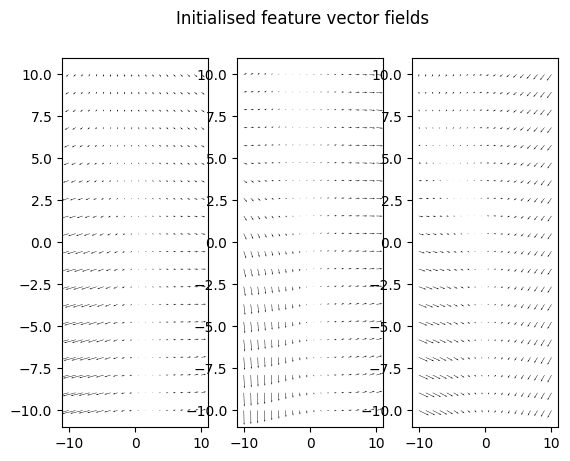

In [26]:
fig, ax = plt.subplots()

# make a figure with 6 subplots arranged in 2 rows and 3 columns
for i in range(c):
    ax = plt.subplot(1, 3, i+1)
    plot_component_vf(vf, ax, comp = i, x_range=10, y_range=10)


# add a title to the figure
fig.suptitle('Initialised feature vector fields')


plt.show()

In [29]:
epochs = 5

orig_labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))

optim = torch.optim.SGD(vf.parameters(), lr=1e-4, momentum=0.9)

for e in range(epochs):

    print(e)

    ## shuffle the data
    idx = np.random.permutation(len(paths))
    paths = [paths[i] for i in idx]
    labels = labels[idx]

    correct_pred = 0

    for i in range(len(paths)):

        p = paths[i]
        y = labels[i]
        
        X = generate_cochain_dm(vf, p, n = 5)

        # sum up columns of X using torch
        X = torch.sum(X, dim = 0)

        sm = torch.nn.functional.softmax(X)

        # get the index of the max log-probability
        pred = sm.argmax(dim=0, keepdim=True)

        if pred == orig_labels[i]:
            correct_pred += 1
        




        # and the target y
        loss = torch.nn.functional.cross_entropy(sm,y.float())
        loss.backward()

        optim.step()

        optim.zero_grad()

    print(correct_pred/len(paths))



0


/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/2906867660.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


0.31333333333333335
1
0.36666666666666664
2
0.2966666666666667
3
0.3233333333333333
4
0.26666666666666666


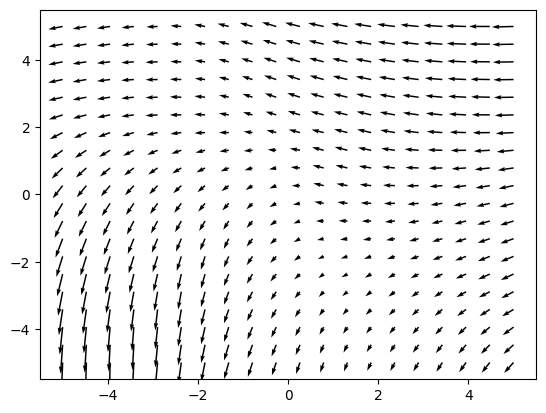

In [33]:
fig, ax = plt.subplots()

plot_component_vf(vf, ax, comp=2, x_range=-5, y_range=5)

plt.show()

Parameter containing:
tensor([[-0.5928, -0.3529],
        [-0.3654, -0.5864],
        [ 0.6180, -0.2092],
        [ 0.6796,  0.5408],
        [-0.3608,  0.1075],
        [ 0.1170,  0.0055],
        [-0.5153, -0.3806],
        [-0.7068, -0.1504],
        [-0.7219,  0.4882],
        [ 0.2575, -0.5976]], requires_grad=True)

## Check with manual initial weights

In [39]:
vf2 = nn.Sequential(
    nn.Linear(2, 6)
)

In [70]:
vf2[0].weight.data = torch.tensor([[0,0],[0,0],[0,-1],[0,0],[0,0],[1,0]], dtype=torch.float)

In [74]:
vf2[0].bias.data = torch.tensor([1,0,0,0,1,0], dtype=torch.float)

In [75]:
vf2[0].weight.T

tensor([[ 0.,  0.,  0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.,  0.,  0.]], grad_fn=<PermuteBackward0>)

In [77]:
vf2.forward(torch.tensor([1,1], dtype=torch.float)).reshape(2,3)

tensor([[ 1.,  0., -1.],
        [ 0.,  1.,  1.]], grad_fn=<ReshapeAliasBackward0>)

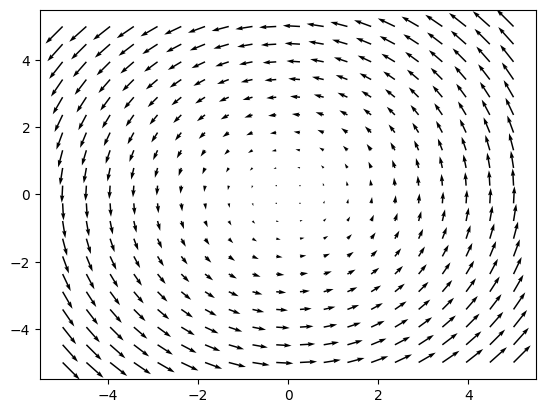

In [81]:
fig, ax = plt.subplots()

plot_component_vf(vf2, ax, comp=2, x_range=-5, y_range=5)

plt.show()

In [84]:


orig_labels = np.concatenate((np.zeros(100),np.ones(100),2*np.ones(100)))


correct_pred = 0

for i in range(len(paths)):

    p = paths[i]
    y = labels[i]
    
    X = generate_cochain_dm(vf2, p, n = 5)

    # sum up columns of X using torch
    X = torch.sum(X, dim = 0)

    sm = torch.nn.functional.softmax(X)

    # get the index of the max log-probability
    pred = sm.argmax(dim=0, keepdim=True)

    if pred == orig_labels[i]:
        correct_pred += 1
    




print(correct_pred/len(paths))

/var/folders/w2/2q_ql79j5_s6kq_b56rg9xdc0000gn/T/ipykernel_822/3483566922.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = torch.nn.functional.softmax(X)


0.34


In [85]:
X

tensor([ 1.6702,  1.7143, -6.5129], grad_fn=<SumBackward1>)